# Network Analysis of Molecular Dynamics Simulations of Colloidal 2d Systems

We want to study how melting transition in 2D systems can be mapped to networks
In this notebook we will show how these concepts can be exploiting using network theory.


# Introduction

The problem of melting in two-dimensional crystals refers to the phenomenon where the solid structure of a crystal breaks down and turns into a liquid. This occurs due to the unbinding of topological defects, which are small areas of disorder in the crystal lattice. When these defects become unbound, they move freely, disrupting the ordered arrangement of the crystal and causing it to lose its solidity.
![fig](figs/hexatic.png)

A perfect two-dimensional crystal is made of particles in hexagonal order, where neighboring particles are arranged in a hexagonal pattern, but with more freedom of movement compared to the solid phase. Lowering the density of the system, we can observe an intermediate phase between solid and liquid, known as the hexatic phase. In this phase, the crystal structure is partially disordered, but still retains some of its ordered arrangements. Lastly, decreasing the density even further, the system will melt into a liquid phase, where the particles are completely disordered and move freely.
![fig](figs/hex-lattice.svg)

The melting is characterized by the increase of topological defects, i.e., particles with a different number of neighbors respect to six. 

In this notebook we will study the increase of topological defect as a function of the density in molecular dynamics simulation using network concepts. We consider simulations made with the software LAMMPS of $N=128^2$ particles inside a box of size $LxL$. The particles have mass $m=1$ and size $\sigma = 1.0$, and evolves through a Langevin equation

In [7]:
import networkx as nx
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

from scipy.spatial import distance_matrix
from utils_network import graph_plotting, grade_analysis, betwenness_analysis
from utils_reading import read_data, smaller_sys, create_graph, reduce_all_confs

# Read and adjust data

The data files contains the points of the particles of the simulation at a given timestep. 

First of all, we want to reduce the size of the configurations to a smaller box of size 100 and 10, to make the computations easier. We can then plot the configurations and the distance matrix to have a nice view of the data.

In [2]:
path = 'ordered_128/Pe0'
data_array, data_fis = read_data(path)

fi_set = set(data_fis)
print(sorted(fi_set))

[0.7, 0.702, 0.704, 0.705, 0.706, 0.708, 0.71, 0.712, 0.714, 0.715, 0.716, 0.718, 0.72, 0.722, 0.723, 0.724, 0.725, 0.726, 0.727, 0.728, 0.729, 0.73, 0.731, 0.732, 0.733, 0.734, 0.735, 0.736, 0.737, 0.738, 0.739, 0.74]


In [3]:
# reduce the size of the configurations in smaller boxes 

new_data_array = reduce_all_confs(data_array, 100)
smaller_data_array = reduce_all_confs(data_array, 10)

# Data visualization

In order to create the adjacency matrix, we compute the distances between al pair of particles in the configurations, then we discretize the distance matrix with the threshold $1.5\sigma$ (this is the minimal distance to have an hexagonal structure), and last we delete the diagonal to avoid self-contacts.

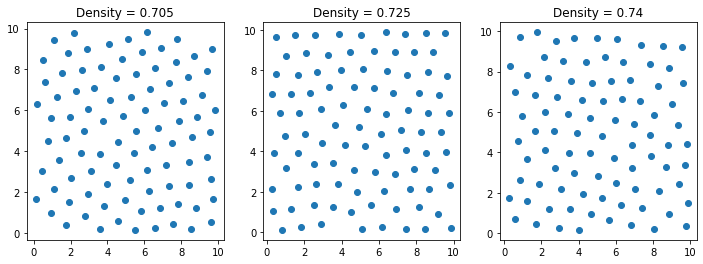

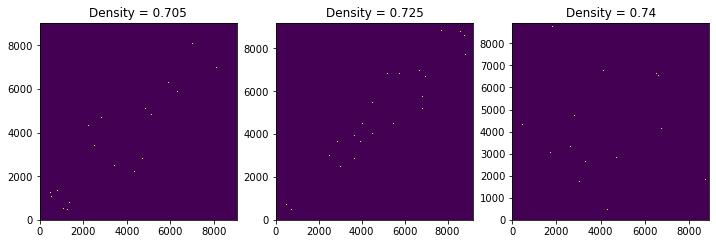

In [4]:
#plot a nice view of the distance matrix and of the configurations

density_analysis_array = [0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740] 


fig_conf, ax_conf = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
fig_dm, ax_dm = plt.subplots(figsize=(12,4), nrows=1, ncols=3)

for index, fi in enumerate([0.705, 0.725, 0.740]):
    # flat the axis array to be able to iterate over it
    ax_conf = ax_conf.flatten()
    ax_dm = ax_dm.flatten()

    dist = distance_matrix(new_data_array[index], new_data_array[index])
    dist_discret = np.where(dist <= 1.5, 1, 0)
    dist_nodiag = dist_discret - np.diag(np.diag(dist_discret))

    ax_conf[index].set_title('Density = {}'.format(fi))
    ax_dm[index].set_title('Density = {}'.format(fi))

    ax_conf[index].plot(smaller_data_array[index][:,0], smaller_data_array[index][:,1], 'o')
    ax_dm[index].imshow(dist_nodiag, origin='lower', interpolation='nearest')
    


# Network Analysis

We start now the network analysis.

In [8]:
# array of the density we want to analyze
density_analysis_array = [0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740] 
colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(density_analysis_array)))


## Clustering

The clustering coefficient give infos about the triads, and we expect to increase as the density increase because the system is more organized in a hexagonal structure.

Here we plot a rapresentation of the nodes (the particles) of the network colored respect to their cluster coefficient.

The graph at density 0.705 is connected
The graph at density 0.71 is connected
The graph at density 0.715 is connected
The graph at density 0.72 is connected
The graph at density 0.725 is connected
The graph at density 0.73 is connected
The graph at density 0.735 is connected
The graph at density 0.74 is connected


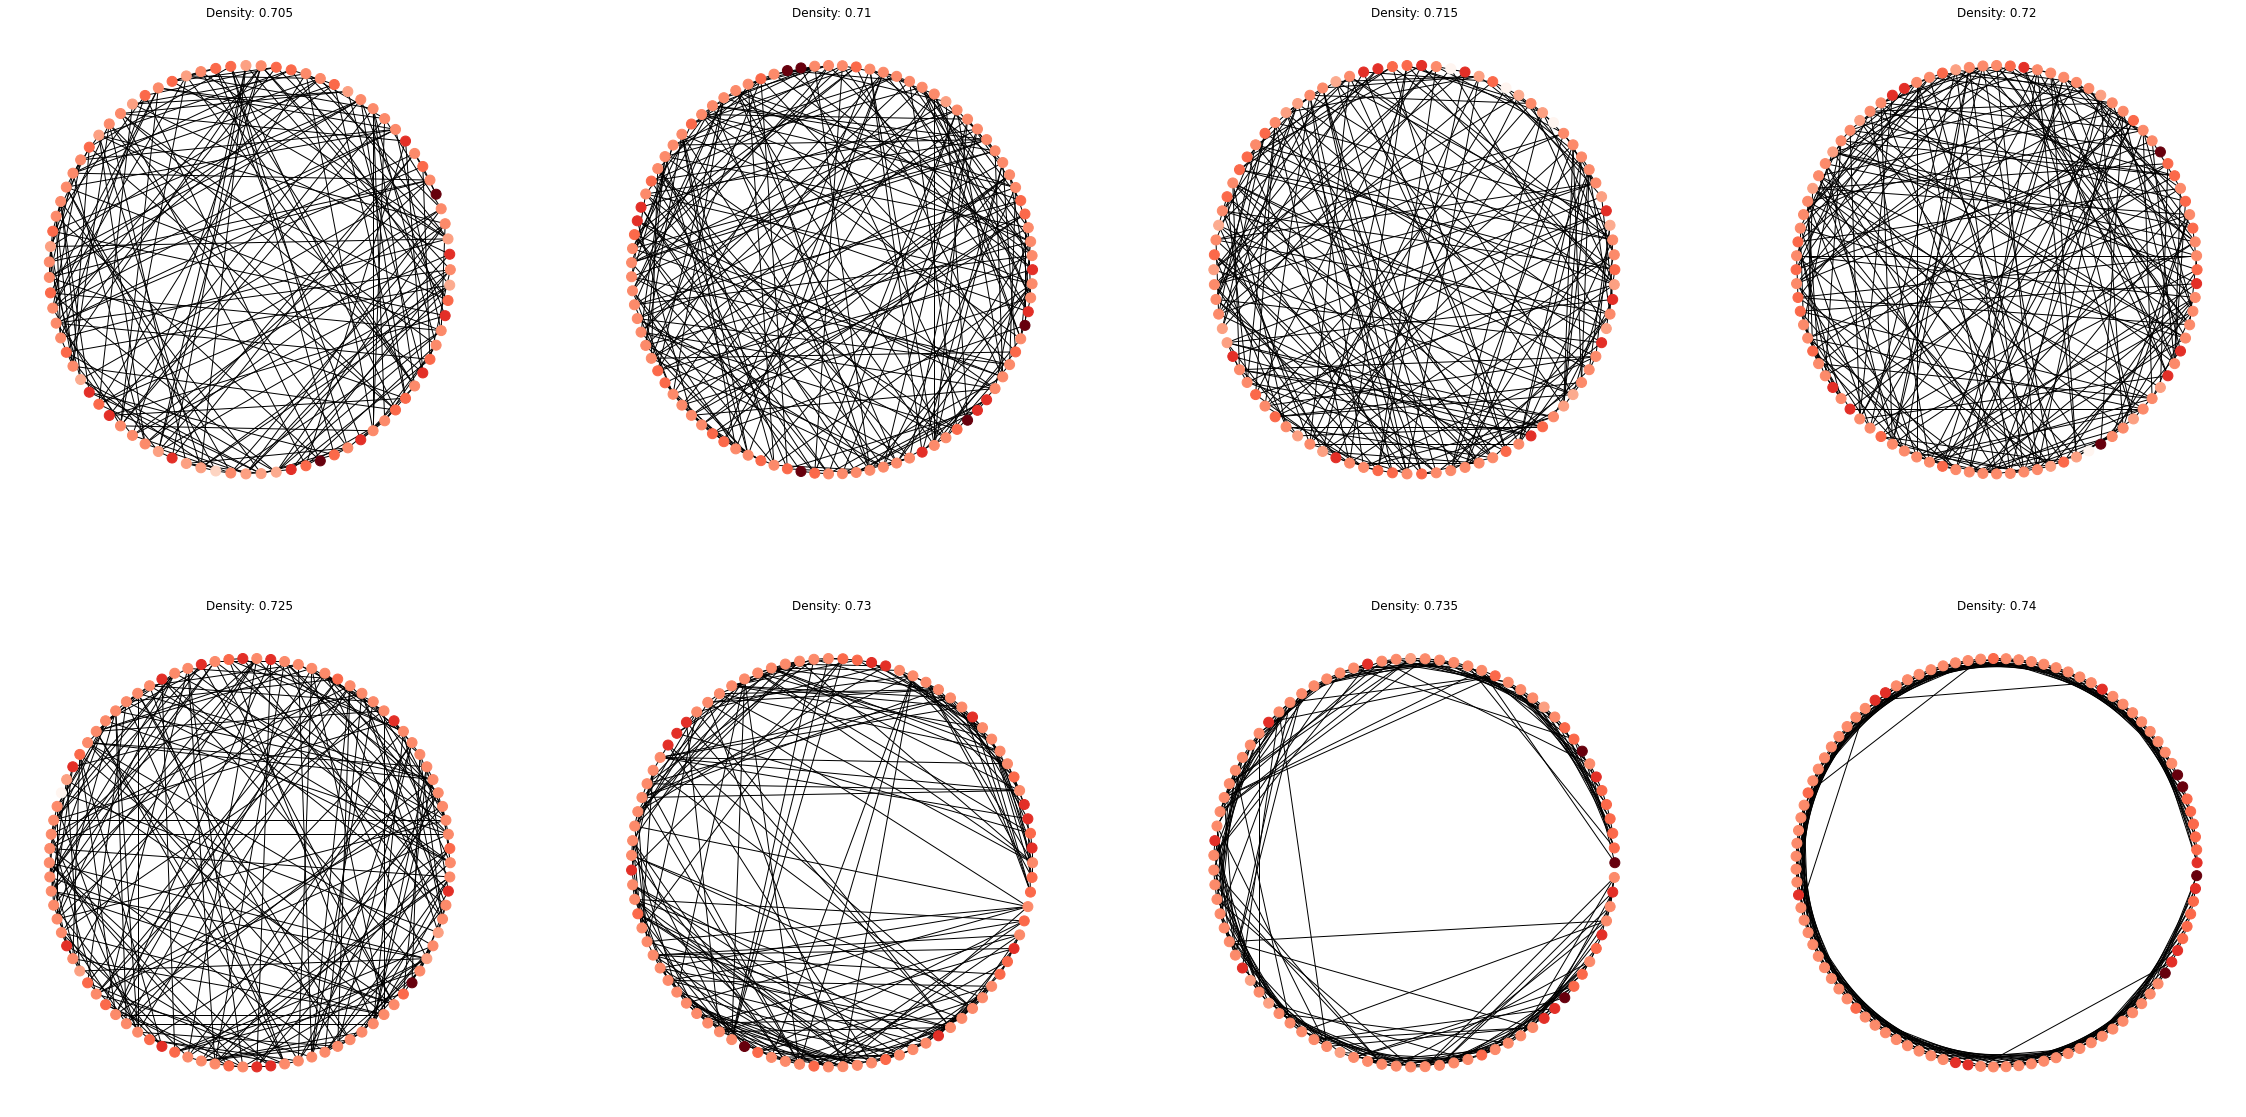

In [5]:

#shortest_path_avg = []
#diameter_avg = []
fig, axs = plt.subplots(figsize=(40,20), nrows=2, ncols=4)
for fi in density_analysis_array:
    G = create_graph(new_data_array, data_fis, fi)
    if nx.is_connected(G):
        print(f'The graph at density {fi} is connected')
    G_small = create_graph(smaller_data_array, data_fis, fi)
    # select axis with index
    ax = axs.flat[density_analysis_array.index(fi)]
    # plot the graph
    clustering = nx.clustering(G_small)
    ax.set_title('Density: ' + str(fi))
    # plot circular graph

    nx.draw(G_small, with_labels=False, ax=ax, pos=nx.circular_layout(G_small),
            font_weight='bold', node_size=100, node_color=list(clustering.values()),
            cmap=plt.cm.Reds, vmin=0, vmax=1)
    #shortest_path_avg.append(nx.average_shortest_path_length(G_small))
    #diameter_avg.append(nx.diameter(G_small))


In this rapresentation the networks resemble very much a random graph. We have a random graph with low attachment probability at small densities. Increasing the density, it is like increasing the attachment probability, and the network becomes more organized. This reflects the more organization in the hexagonal structure of the particles.  

## Averages

We now compute the distribution of the grade of the network, and the average as a function of density of some 

(0.39, 0.405)

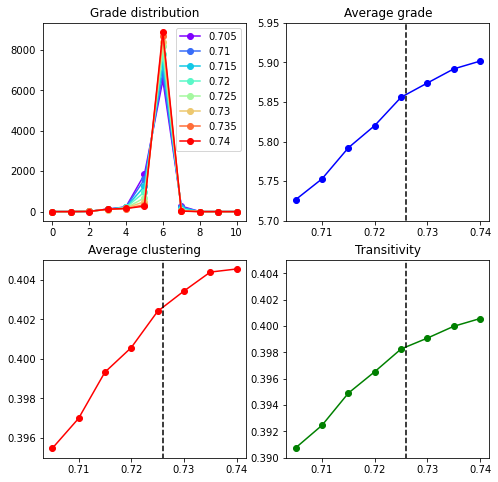

In [13]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2)
grade_avg = []
clustering_avg = []
transitivity_avg = []
for fi in density_analysis_array:
    G = create_graph(new_data_array, data_fis, fi)
    grade_hist, grade_bins = grade_analysis(G, verbose=False)
    ax[0,0].plot(grade_bins[:-1], grade_hist, 'o-', label=fi, color=colors[density_analysis_array.index(fi)])
    # average of all the degrees
    grade_avg.append(np.average(np.array([d for n, d in G.degree()])))
    clustering_avg.append(nx.average_clustering(G))
    transitivity_avg.append(nx.transitivity(G))
ax[0,0].legend()

ax[0,1].plot(density_analysis_array, grade_avg, 'o-', color='blue')
ax[1,0].plot(density_analysis_array, clustering_avg, 'o-', color='red')
ax[1,1].plot(density_analysis_array, transitivity_avg, 'o-', color='green')
#ax[0,2].plot(density_analysis_array, shortest_path_avg, 'o-', color='orange')
#ax[1,2].plot(density_analysis_array, diameter_avg, 'o-', color='purple')

ax[0,1].vlines(0.726, 0, 10, color='black', linestyle='--')
ax[1,0].vlines(0.726, 0, 1, color='black', linestyle='--')
ax[1,1].vlines(0.726, 0, 1, color='black', linestyle='--')

ax[0,0].set_title('Grade distribution')
ax[0,1].set_title('Average grade')
ax[1,0].set_title('Average clustering')
ax[1,1].set_title('Transitivity')
#ax[0,2].set_title('Average shortest path')
#ax[1,2].set_title('Diameter')

ax[0,1].set_ylim(5.70, 5.95)
ax[1,0].set_ylim(0.395, 0.405)
ax[1,1].set_ylim(0.390, 0.405)


The increase is small, but -> size of the system and number of defects

The distribution of the grade is peaked around $6$, which is the number of particles that can be arranged in an hexagonal lattice. But there are deviations in the distribution as teh density is deacrease, meaning that there is the apparition of particles with less neighbors - the topological defects. This confirm that the phase transition is mediated by the relase of such defect. The average grade, as such, increase with the density and reach almost 6 . Also the clustering and the transitivity (related to the clustering coefficient)

## Betwenees Centrality 

We compute the betwenees centrality of every node, that is the number of shortest paths that pass through the node. 

system more organized in hexagonal structures

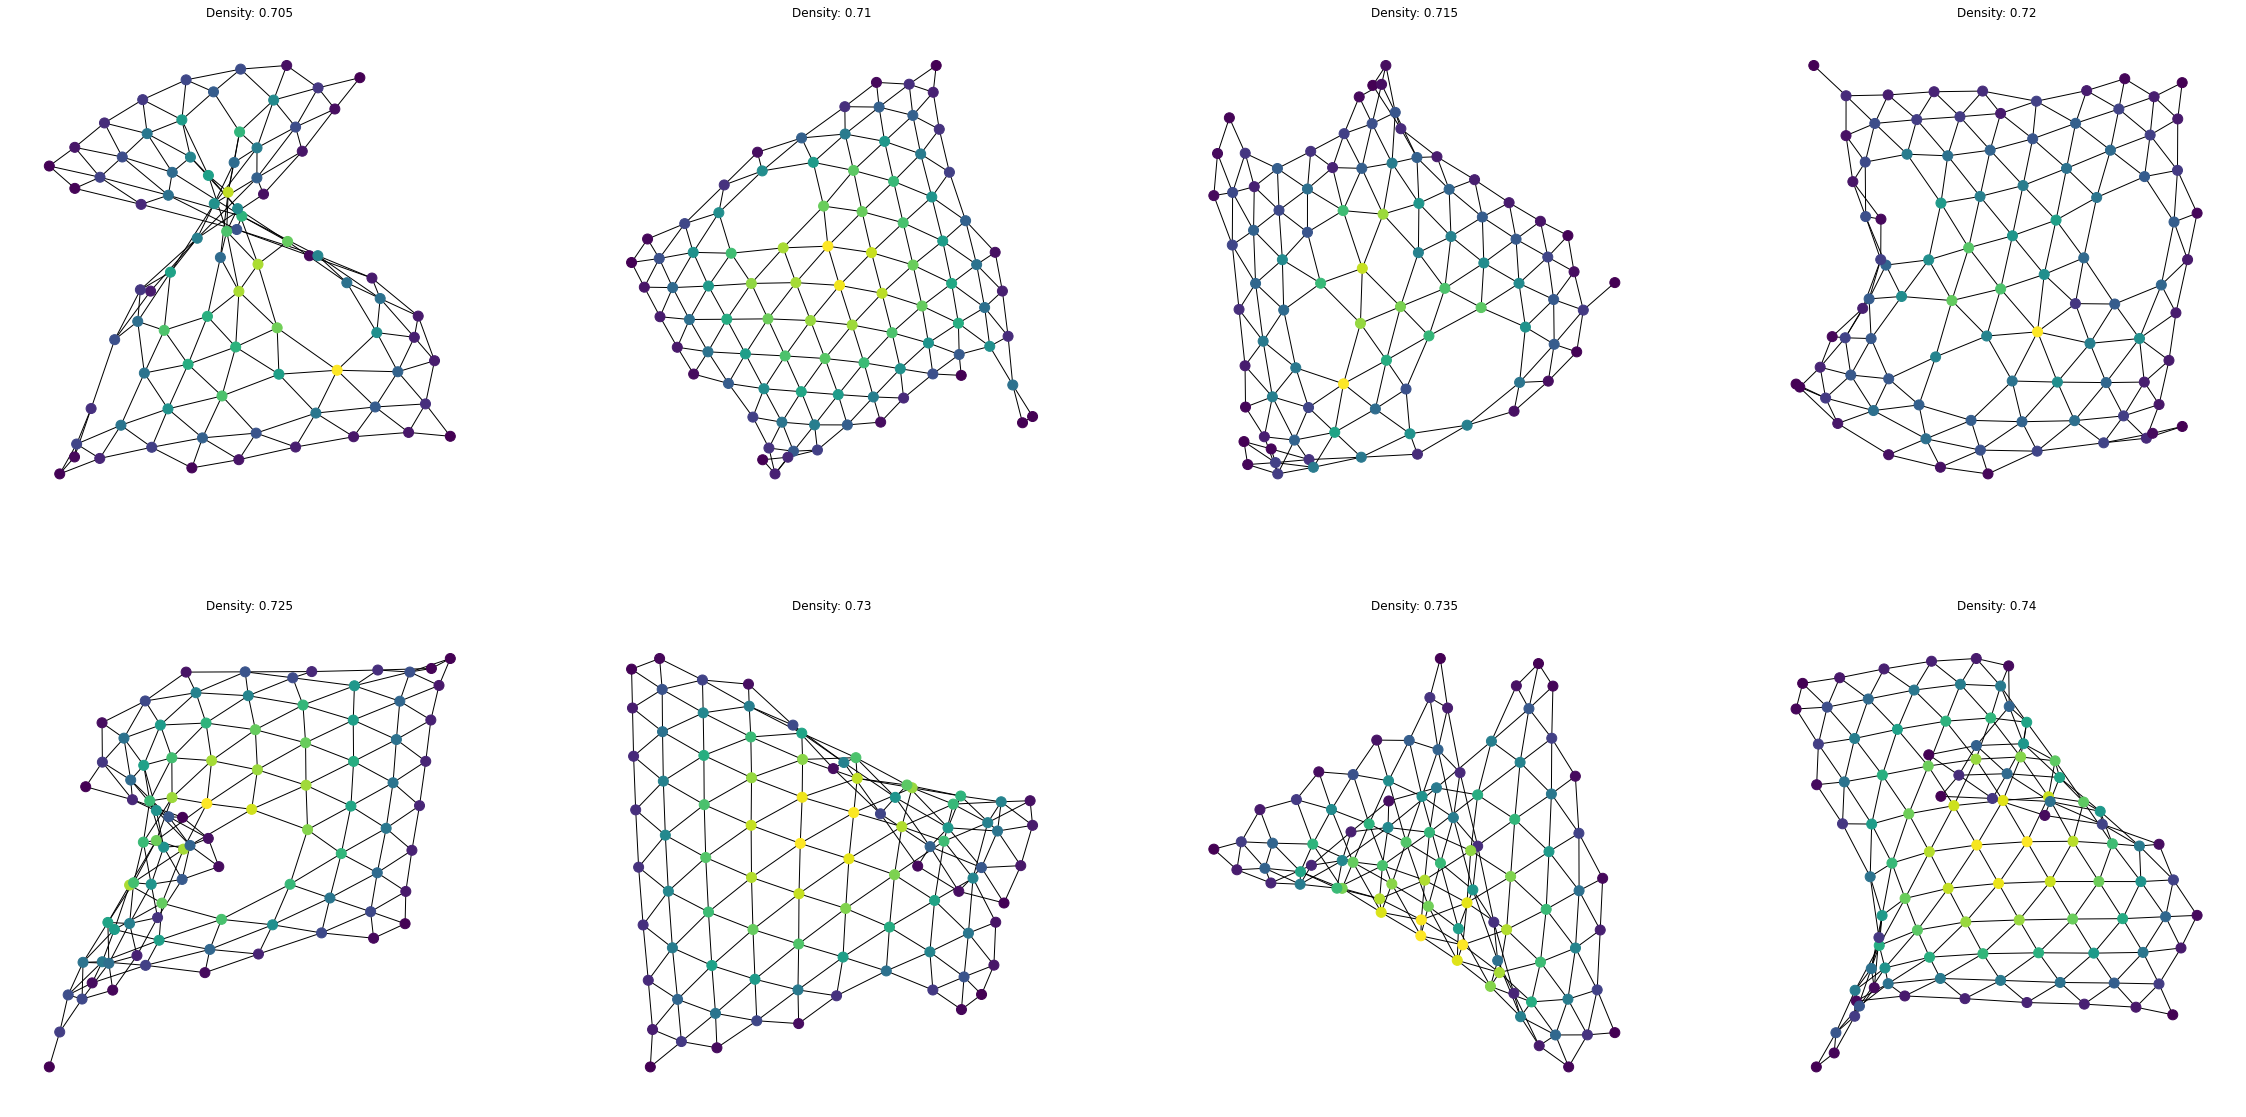

In [ ]:

fig, axs = plt.subplots(figsize=(40,20), nrows=2, ncols=4)
for fi in density_analysis_array:
    G_small = create_graph(smaller_data_array, data_fis, fi)
    ax = axs.flat[density_analysis_array.index(fi)]
    betwenness_centr = nx.betweenness_centrality(G_small)
    betw_hist, betw_bins = np.histogram(list(betwenness_centr.values()), bins='auto')
    #ax.set_xrange(0,0.2)
    ax.set_title('Density: ' + str(fi))
    #ax.set_yscale('log')
    #ax.bar(betw_bins[:-1], betw_hist, width=0.01, color=colors[density_analysis_array.index(fi)],alpha=0.5)
    nx.draw(G_small, with_labels=False, ax=ax,  
        font_weight='bold', node_size=100, node_color=list(betwenness_centr.values()),
        cmap=plt.cm.viridis, vmin=np.min(list(betwenness_centr.values())), vmax=np.max(list(betwenness_centr.values())))
#fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1)), ax=axs[:, 3], shrink=0.6, cmap=plt.cm.viridis)



## Closeness centrality

Then we analyze the closeness centrality, which is the inverse of the average distance of a node to all the other nodes. We expect to have a peak around the nodes that are in the center of the network, and a decrease of the value as the node is far from the center.

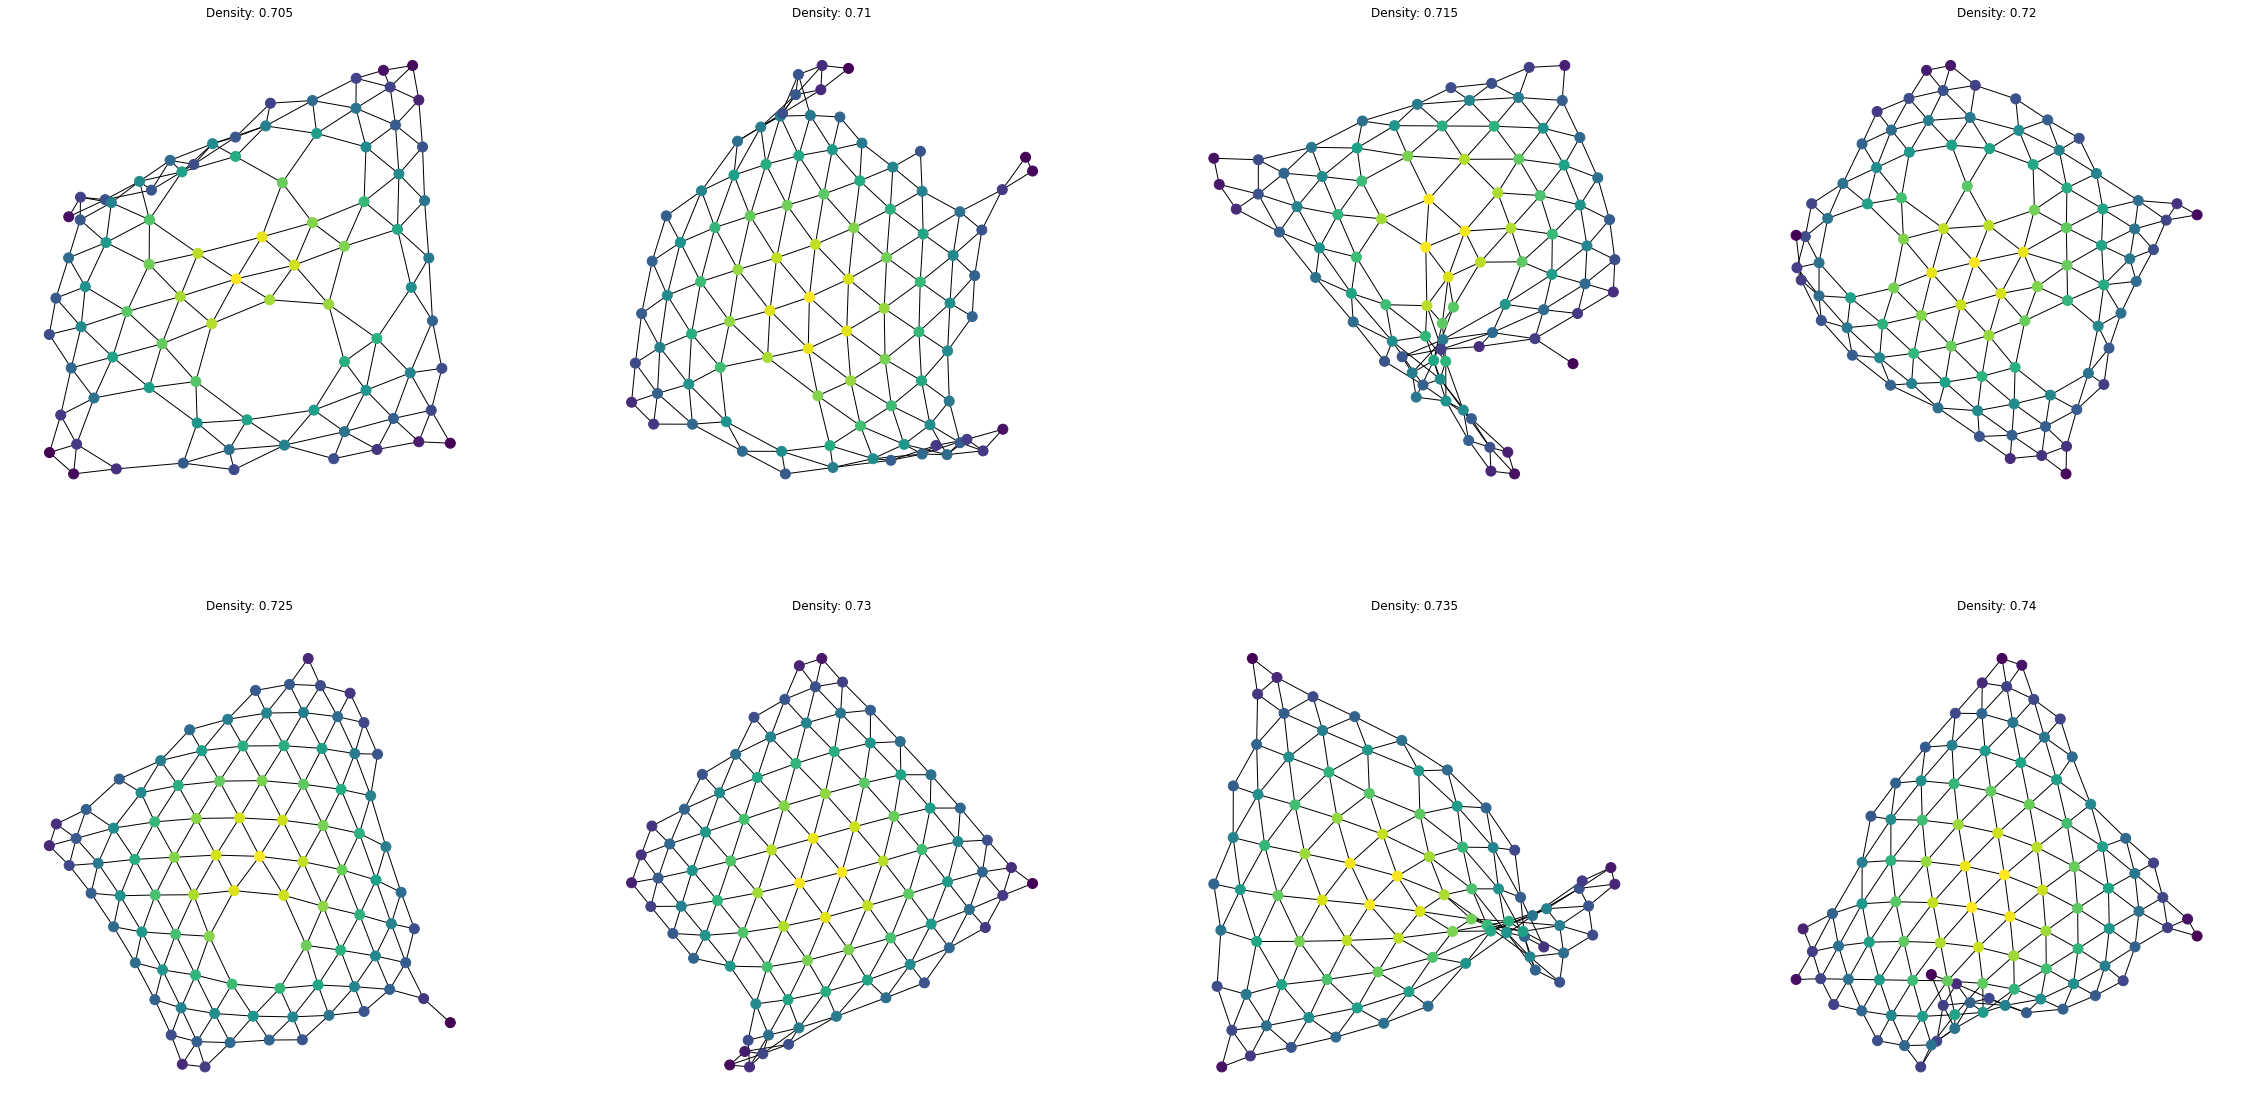

In [ ]:

fig, axs = plt.subplots(figsize=(40,20), nrows=2, ncols=4)
for fi in density_analysis_array:
    G_small = create_graph(smaller_data_array, data_fis, fi)
    ax = axs.flat[density_analysis_array.index(fi)]
    closeness_centr = nx.closeness_centrality(G_small)
    betw_hist, betw_bins = np.histogram(list(closeness_centr.values()), bins='auto')
    #ax.set_xrange(0,0.2)
    ax.set_title('Density: ' + str(fi))
    #ax.set_yscale('log')
    #ax.bar(betw_bins[:-1], betw_hist, width=0.01, color=colors[density_analysis_array.index(fi)],alpha=0.5)
    nx.draw(G_small, with_labels=False, ax=ax, 
        font_weight='bold', node_size=100, node_color=list(closeness_centr.values()),
        cmap=plt.cm.viridis, vmin=np.min(list(closeness_centr.values())), vmax=np.max(list(closeness_centr.values())))
#fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1)), ax=axs[:, 3], shrink=0.6, cmap=plt.cm.viridis)


# Future developements

- Add the computation of the PBC (periodic boundary conditions) to the distance matrix